# Direct optimal control of a pendulum

We want to control an inverted pendulum and stabilize it in the upright position. The equations in Hamiltonian form describing an inverted pendulum with a torsional spring are as following:

$$\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}$$

In [22]:
import sys; sys.path.append(2*'../') # go n dirs back
import matplotlib.pyplot as plt

import torch
from torchdyn.numerics.odeint import odeint
from torchcontrol.systems.classic_control import Pendulum
from torchcontrol.cost import IntegralCost
from torchcontrol.controllers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)
device = torch.device('cpu') # override

## Optimal control problem
In order to control the pendulum, we have to define a proper _integral cost function_ which will be our loss to be minimized during training. In a general form, it can be defined as:

$$\begin{equation}
        \min_{u_\theta} J = (x(t_f) - x^\star)^\top\mathbf{P} (x(t_f) - x^\star)) + \int_{t_0}^{t_f} \left[ (x(t) - x^\star)^\top \mathbf{Q} (x(t) - x^\star) + (u_\theta(t) - u^\star)^\top \mathbf{R} (u_\theta(t) - u^\star) \right] dt
\end{equation}$$

where $ x $ is the state and $u_\theta$ is the controller; $x^\star$ and $u^\star$ are the desired position and zero-cost controller; matrices $\mathbf{P},~\mathbf{Q}, ~ \mathbf{R}$ are weights for tweaking the performance.

In [24]:
# Declaring the cost function
x_star = torch.Tensor([0, 0]).to(device)
u_star = 0.
cost = IntegralCost(x_star=x_star, u_star=u_star, P=0, Q=1, R=0)

## Initial conditions
Now we can see how the system behaves with no control input in time. Let's declare some initial variables:

In [25]:
from math import pi as π

# Time span
dt = 0.05 # step size
t0, tf = 0, 3 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x_0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x_0, -x_0]), torch.Tensor([x_0, x_0]))

## Box-constrained controller
We want to give a limited control input. We consider the box-constrained neural controller (parameters $\theta$ of $u_\theta$ belong to a feed-forward neural network):

In [26]:
?? BoxConstrainedController

Init signature:
 BoxConstrainedController(
    in_dim,
    out_dim,
    h_dim=64,
    num_layers=2,
    zero_init=True,
    input_scaling=None,
    output_scaling=None,
    constrained=False,
)
Source:        
class BoxConstrainedController(nn.Module):
    """Simple controller  based on a Neural Network with
    bounded control inputs

    Args:
        in_dim: input dimension
        out_dim: output dimension
        hid_dim: hidden dimension
        zero_init: initialize last layer to zeros
    """
    def __init__(self, 
                 in_dim, 
                 out_dim, 
                 h_dim=64, 
                 num_layers=2, 
                 zero_init=True,
                 input_scaling=None, 
                 output_scaling=None,
                 constrained=False):
        
        super().__init__()
        # Create Neural Network
        layers = []
        layers.append(nn.Linear(in_dim, h_dim))
        for i in range(num_layers):
            if i < num_layers-1:
      

In [43]:
# Controller
output_scaling = torch.Tensor([-5, 5]).to(device) # controller limits
u = BoxConstrainedController(2, 1, constrained=True, output_scaling=output_scaling).to(device)

# Initialize pendulum with given controller
pendulum = Pendulum(u, solver='euler')

## Optimization loop
Here we run the optimization: in particular, we use stochastic gradient descent with `Adam` to optimize the parameters

In [44]:
from tqdm import trange

# Hyperparameters
lr = 1e-3
epochs = 300
bs = 1024
opt = torch.optim.Adam(u.parameters(), lr=lr)

# Training loop
losses=[]
with trange(0, epochs, desc="Epochs") as eps:
    for epoch in eps:    
        x0 = init_dist.sample((bs,)).to(device)
        trajectory = pendulum(x0, t_span)  
        loss = cost(trajectory); losses.append(loss.detach().cpu().item())
        loss.backward(); opt.step(); opt.zero_grad()
        eps.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 300/300 [00:24<00:00, 12.34it/s, loss=1.26]


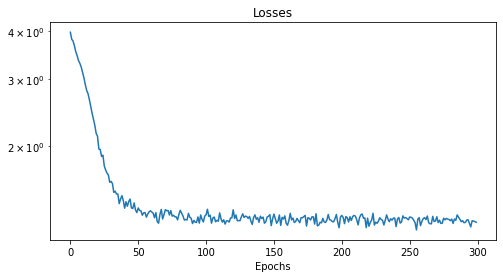

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(losses)
ax.set_title('Losses')
ax.set_xlabel('Epochs')
ax.set_yscale('log')

## Plot results

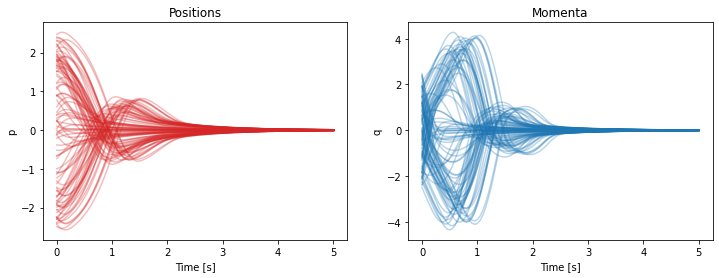

In [57]:
# Change the solver to 'dopri5' (adaptive step size, more accurate than Euler)
pendulum.solver = 'dopri5'

# Forward propagate some trajectories 
x0 = init_dist.sample((100,)).to(device)*0.8

# Prolong time span
dt = 0.05 # step size
t0, tf = 0, 5 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

traj = pendulum(x0, t_span)

def plot_pendulum_trajs():
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    for i in range(len(x0)):
        axs[0].plot(t_span.cpu(), traj[:,i,0].detach().cpu(), 'tab:red', alpha=.3)
        axs[1].plot(t_span.cpu(), traj[:,i,1].detach().cpu(), 'tab:blue', alpha=.3)
    axs[0].set_xlabel(r'Time [s]'); axs[1].set_xlabel(r'Time [s]')
    axs[0].set_ylabel(r'p'); axs[1].set_ylabel(r'q')
    axs[0].set_title(r'Positions'); axs[1].set_title(r'Momenta')

plot_pendulum_trajs()

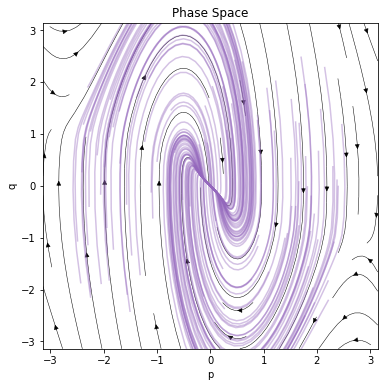

In [59]:
# Plot learned vector field and trajectories in phase space
n_grid = 50
graph_lim = π

def plot_phase_space():
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    x = torch.linspace(-graph_lim, graph_lim, n_grid).to(device)
    Q, P = torch.meshgrid(x, x) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], 1)
    f = pendulum.dynamics(0, z).detach().cpu()
    Fq, Fp = f[:,0].reshape(n_grid, n_grid), f[:,1].reshape(n_grid, n_grid)
    val = pendulum.u(0, z).detach().cpu()
    U = val.reshape(n_grid, n_grid)
    ax.streamplot(Q.T.detach().cpu().numpy(), P.T.detach().cpu().numpy(),
                    Fq.T.detach().cpu().numpy(), Fp.T.detach().cpu().numpy(), color='black', density=0.6, linewidth=0.5)

    ax.set_xlim([-graph_lim, graph_lim]) ; ax.set_ylim([-graph_lim, graph_lim])
    traj = pendulum(x0, t_span).detach().cpu()
    for j in range(traj.shape[1]):
        ax.plot(traj[:,j,0], traj[:,j,1], color='tab:purple', alpha=.4)
    ax.set_title('Phase Space')
    ax.set_xlabel(r'p')
    ax.set_ylabel(r'q')
    
plot_phase_space()

Nice! The controller manages to stabilize the pendulum in our desired $x^\star$ 🎉